<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/PVT/eclipseFluidCharNeqSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Python packages read Eclipse file and import Python libraries

In [1]:
%%capture
!pip install neqsim
!pip install wget
!wget https://raw.githubusercontent.com/EvenSol/NeqSim-Colab/master/notebooks/PVT/examplefile.txt
!wget https://raw.githubusercontent.com/EvenSol/NeqSim-Colab/master/notebooks/PVT/example2.txt
import neqsim
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

#Create original reservoir fluid composition

##Read fluid from Eclipse 300 file

In [2]:
file1 = open('example2.txt', "r")
FileContent = file1.read()
print(FileContent)

﻿-- Dummy EOS for FluidMagic Test case
-- 
-- Copyright (C) 2022 Equinor 


-- Units
METRIC
-- Number of components:
NCOMPS
22 /
-- Equation of state
EOS
PR /
PRCORR


-- Reservoir temperature (C)
RTEMP
     90.00 /


-- Standard Conditions (C and bara)
STCOND
   15.00000    1.01325  /


-- Component names
CNAMES
N2
CO2
C1
C2
C3
iC4
C4
iC5
C5
C6
C7
C8
C9
C10-C12
C13-C14
C15-C17
C18-C21
C22-C28
C29-C36
C37-C45
C46-C58
C59-C80 /
-- Tc (K)
TCRIT
   126.200
   304.200
   190.600
   305.400
   369.800
   408.100
   425.200
   460.400
   469.600
   507.400
   548.083
   568.470
   592.686
   631.845
   680.299
   727.035
   774.284
   851.846
   943.373
  1038.592
  1152.236
  1317.304 /
-- Pc (Bar)
PCRIT
   33.9439
   73.7646
   46.0015
   48.8387
   42.4552
   36.4770
   37.9969
   33.8426
   33.7412
   29.6882
   29.4519
   27.6423
   25.5535
   22.7296
   20.0143
   18.1224
   16.7108
   15.1759
   14.0297
   13.2891
   12.7370
   12.2645 /
-- Omega
ACF
   0.04000
   0.22500
   0.00800
 

##Create NeqSim fluid from Eclipse file
Run TP flash at reservoir temperature and pressure

In [3]:
fluid1 = readEclipseFluid('example2.txt')

reservoirPressure = 100
fluid1.setPressure(reservoirPressure, 'bara')
reservoirTemperature = 90.0 # C
fluid1.setTemperature(reservoirTemperature, 'C')

satpres = bubp(fluid1)
TPflash(fluid1)


print('saturation pressure at 90C ', fluid1.getPressure('bara'), ' bara')

printFrame(fluid1)

fluid1.setPressure(fluid1.getPressure()-2.0)
TPflash(fluid1)
printFrame(fluid1)

saturation pressure at 90C  189.774834606021  bara
| 0                  | 1           | 2                | 3   | 4   | 5   | 6               |
|:-------------------|:------------|:-----------------|:----|:----|:----|:----------------|
|                    | total       | OIL              |     |     |     |                 |
| nitrogen           | 3.912E-3    | 3.912E-3         |     |     |     | [mole fraction] |
| CO2                | 3.01E-3     | 3.01E-3          |     |     |     | [mole fraction] |
| methane            | 4.03275E-1  | 4.03275E-1       |     |     |     | [mole fraction] |
| ethane             | 7.6341E-2   | 7.6341E-2        |     |     |     | [mole fraction] |
| propane            | 7.9752E-2   | 7.9752E-2        |     |     |     | [mole fraction] |
| i-butane           | 1.1938E-2   | 1.1938E-2        |     |     |     | [mole fraction] |
| n-butane           | 4.0929E-2   | 4.0929E-2        |     |     |     | [mole fraction] |
| i-pentane          | 1.3944

#Step 1 - Generate true well compositions - Run reservoir simulations in NeqSim

##Set up reservoir simulation

We run a reservoir simulation for 10 years

gas production  7.833684952729038  MSm3/day
oil production  47827.73122316262  Sm3/day
oil production  300836.4293936929  bbl/day
gas production  7.360215262581373  MSm3/day
oil production  52311.69982991906  Sm3/day
oil production  329040.5919301909  bbl/day
gas production  5.824498213326229  MSm3/day
oil production  44772.86821645423  Sm3/day
oil production  281621.34108149714  bbl/day
gas production  5.092338487779276  MSm3/day
oil production  41794.08446319026  Sm3/day
oil production  262884.7912734667  bbl/day
gas production  4.543091667056005  MSm3/day
oil production  39454.232210980954  Sm3/day
oil production  248167.1206070702  bbl/day
gas production  4.111525627604314  MSm3/day
oil production  37534.19563582159  Sm3/day
oil production  236090.0905493178  bbl/day
gas production  3.7611415047107033  MSm3/day
oil production  35911.06398001721  Sm3/day
oil production  225880.59243430823  bbl/day
gas production  3.469616047138748  MSm3/day
oil production  34508.93311540597  Sm3/day

Text(0, 0.5, 'methane in reservoir oil [mole frac]')

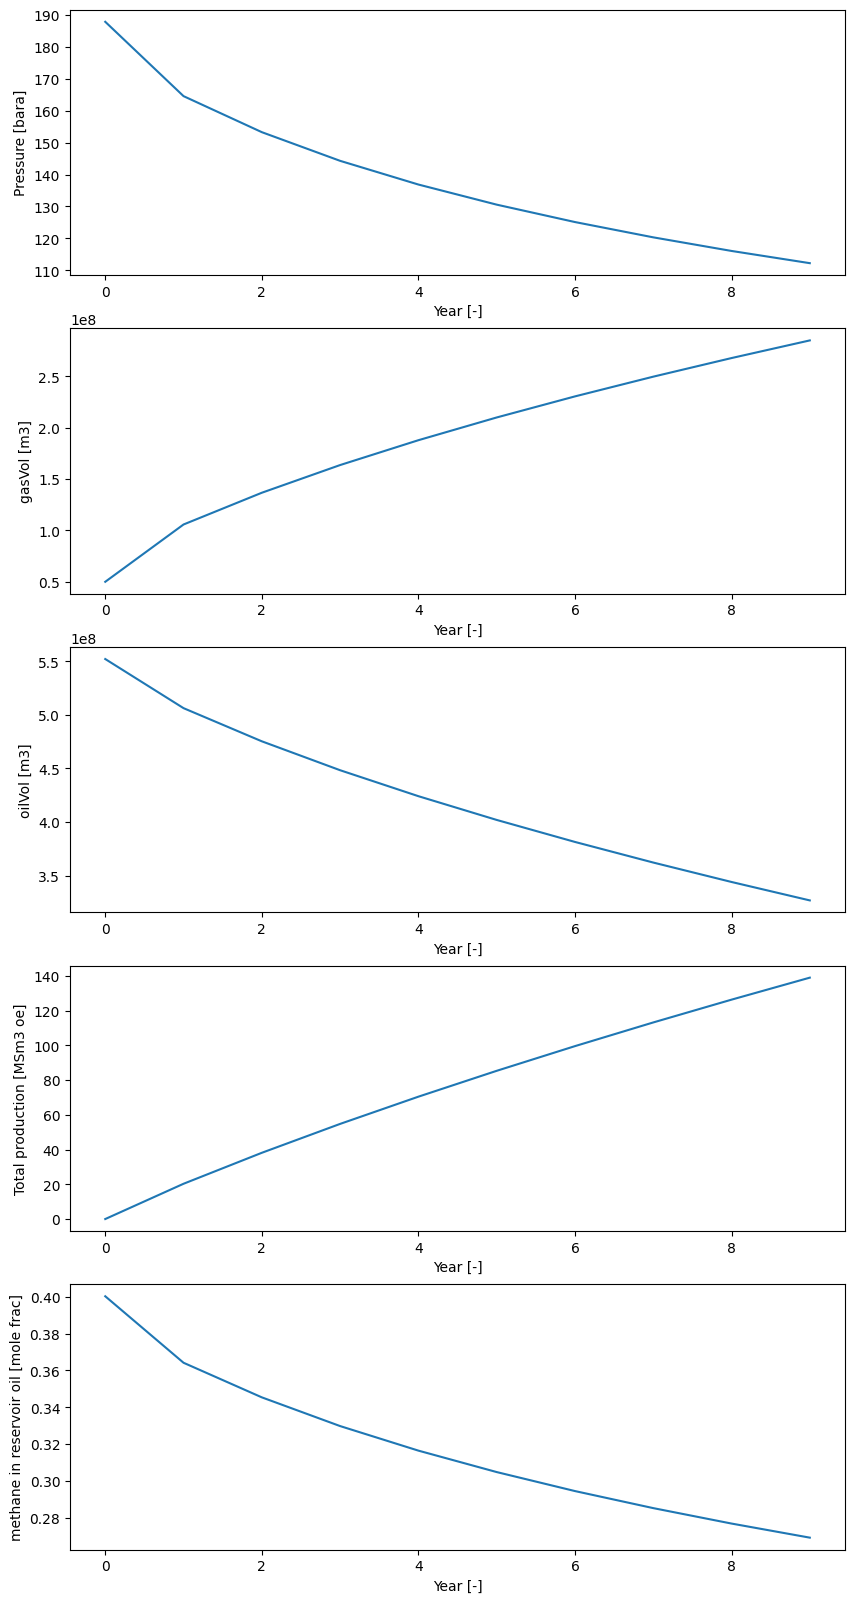

In [4]:
from neqsim.process.processTools import simplereservoir
from neqsim.thermo.thermoTools import *

resfluid = fluid1.clone()
reservoirOps = simplereservoir(resfluid, "Well 1 reservoir", gasvolume=5.0 * 1e7, oilvolume=552.0 * 1e6, watervolume=10.0e6)

producedGasStream = reservoirOps.addGasProducer("SLP_A32562G")
producedGasStream.setFlowRate(0.01, "MSm3/day")

injectionGasStream = reservoirOps.addGasInjector("SLP_A32562GI")
fluidComposition(injectionGasStream.getFluid(), resfluid.getPhase('gas').getMolarComposition())
injectionGasStream.setFlowRate(0.01, "MSm3/day")

producedOilStream = reservoirOps.addOilProducer("SLP_A32562O")
producedOilStream.setFlowRate(50000000.0, "kg/day")


deltat = 24*60*60.0*365
time = []
pressure = []
gasvolume = []
watervolume = []
oilvolume = []
wateringas = []
totalproducedoe = []
C1reservoiroil = []
co2reservoirgas = []
production = []

reservoirOps.run()

for t in range(10):
    time.append(t*deltat/(24*60*60.0*365))
    production.append(producedOilStream.clone())
    pressure.append(reservoirOps.getReservoirFluid().getPressure('bara'))
    gasvolume.append(reservoirOps.getReservoirFluid().getPhase("gas").getVolume("m3"))
    oilvolume.append(reservoirOps.getReservoirFluid().getPhase("oil").getVolume("m3"))
    totalproducedoe.append(reservoirOps.getProductionTotal('MSm3 oe'))
    co2reservoirgas.append(reservoirOps.getReservoirFluid().getComponent('CO2').getz())
    C1reservoiroil.append(reservoirOps.getReservoirFluid().getPhase('oil').getComponent('methane').getx())
    print('gas production ' , reservoirOps.getGasProdution('Sm3/day')/1e6, ' MSm3/day')
    print('oil production ' , reservoirOps.getOilProdution('Sm3/day'), ' Sm3/day')
    print('oil production ' , reservoirOps.getOilProdution('Sm3/day')*6.29, ' bbl/day')
    producedOilStream.setFlowRate(50000000.0*pressure[t]/pressure[0], "kg/day")
    reservoirOps.runTransient(deltat)

plt.rcParams['figure.figsize'] = [10, 20]
#fig, ax = plt.subplots()
plt.subplot(5, 1, 1)
plt.plot(time, pressure)
plt.xlabel('Year [-]')
plt.ylabel('Pressure [bara]')
plt.subplot(5, 1, 2)
plt.plot(time, gasvolume)
plt.xlabel('Year [-]')
plt.ylabel('gasVol [m3]')
plt.subplot(5, 1, 3)
plt.plot(time, oilvolume)
plt.xlabel('Year [-]')
plt.ylabel('oilVol [m3]')
plt.subplot(5, 1, 4)
plt.plot(time, totalproducedoe)
plt.xlabel('Year [-]')
plt.ylabel('Total production [MSm3 oe]')
plt.subplot(5, 1, 5)
plt.plot(time, C1reservoiroil)
plt.xlabel('Year [-]')
plt.ylabel('methane in reservoir oil [mole frac]')


In [5]:
printFrame(production[0].getFluid())
printFrame(production[4].getFluid())

| 0                  | 1           | 2                | 3   | 4   | 5   | 6               |
|:-------------------|:------------|:-----------------|:----|:----|:----|:----------------|
|                    | total       | OIL              |     |     |     |                 |
| nitrogen           | 3.85001E-3  | 3.85001E-3       |     |     |     | [mole fraction] |
| CO2                | 3.00688E-3  | 3.00688E-3       |     |     |     | [mole fraction] |
| methane            | 4.0033E-1   | 4.0033E-1        |     |     |     | [mole fraction] |
| ethane             | 7.62831E-2  | 7.62831E-2       |     |     |     | [mole fraction] |
| propane            | 7.99184E-2  | 7.99184E-2       |     |     |     | [mole fraction] |
| i-butane           | 1.19778E-2  | 1.19778E-2       |     |     |     | [mole fraction] |
| n-butane           | 4.10952E-2  | 4.10952E-2       |     |     |     | [mole fraction] |
| i-pentane          | 1.40155E-2  | 1.40155E-2       |     |     |     | [mole 

#Step 2 -Generate measured test rates (Measure gas and oil volumes at test separator conditions)

We assume 1.01325 bar and 15 C test separator condition

In [6]:
from neqsim.process import *

gasflow = []
oilflow = []
molWg = []

for t in range(10):
  wellTP = heater(production[t])
  wellTP.setOutTemperature(15.0, 'C')
  wellTP.setOutPressure(1.01325, 'bara')
  wellTP.run()

  sep1 = separator(wellTP.getOutStream())
  sep1.run()

  gasflow.append(sep1.getGasOutStream().getFlowRate('MSm3/day'))
  oilflow.append(sep1.getLiquidOutStream().getFlowRate('m3/hr'))
  molWg.append(sep1.getGasOutStream().getFluid().getMolarMass())

  print('gas ' , sep1.getGasOutStream().getFlowRate('MSm3/day'), 'MSm3/day')
  print('oil ' , sep1.getLiquidOutStream().getFlowRate('m3/hr')*24, 'm3/day')
  print('gas ' , sep1.getGasOutStream().getFlowRate('kg/day'), 'kg/day')
  print('oil ' , sep1.getLiquidOutStream().getFlowRate('kg/day'), 'kg/day')

gas  7.876524169012978 MSm3/day
oil  50327.2748118162 m3/day
gas  8872191.859172013 kg/day
oil  41127802.205379136 kg/day
gas  7.402138010282816 MSm3/day
oil  55050.338596552516 m3/day
gas  8529312.329497673 kg/day
oil  44954092.36264147 kg/day
gas  5.8566038718276054 MSm3/day
oil  47116.72805092645 m3/day
gas  6831884.41959326 kg/day
oil  38458559.744616374 kg/day
gas  5.1199196853684485 MSm3/day
oil  43981.366017630644 m3/day
gas  6035148.524570398 kg/day
oil  35885497.91501406 kg/day
gas  4.56722612756854 MSm3/day
oil  41518.26933719586 m3/day
gas  5432698.819228672 kg/day
oil  33864206.31981814 kg/day
gas  4.132910625171048 MSm3/day
oil  39496.98920032782 m3/day
gas  4955656.328137337 kg/day
oil  32205680.861605883 kg/day
gas  3.780261365002877 MSm3/day
oil  37788.22188398869 m3/day
gas  4565458.404226845 kg/day
oil  30803816.254057903 kg/day
gas  3.4868245632088137 MSm3/day
oil  36312.09779948228 m3/day
gas  4238483.994919087 kg/day
oil  29593046.07614065 kg/day
gas  3.23795704164

# Step 3-5- Topside recombination to match oil and gas rates to calculate the wellstream composition  (Run process simulation with original fluid comp, get composition og gas as sep conditions)

In the following we will use original fluid comp

In [7]:
from neqsim.process import *
import jpype
from jpype.types import *

fluidorg = fluid1.clone()
fluidorg.setPressure(50.0)

gasflow2 = []
oilflow2 = []
molWg2 = []
recombinedfluid = []
for t in range(10):
  feedstream = stream(fluidorg)
  feedstream.run()

  flowset =  jNeqSim.processSimulation.processEquipment.util.FlowSetter("flowset", feedstream)
  pressureSep = [1.01325]
  temperatureSep = [15.0]
  flowset.setSeparationPT(JDouble[:](pressureSep), "bara", JDouble[:](temperatureSep), "C");
  flowset.setGasFlowRate(gasflow[t], "MSm3/day")
  flowset.setOilFlowRate(oilflow[t], "m3/hr")
  flowset.run()

  wellTP = heater(flowset.getOutStream())
  wellTP.setOutTemperature(15.0, 'C')
  wellTP.setOutPressure(1.01325, 'bara')
  wellTP.run()

  recombinedfluid.append(flowset.getOutStream())

  sep1 = separator(wellTP.getOutStream())
  sep1.run()

  gasflow2.append(sep1.getGasOutStream().getFlowRate('MSm3/day'))
  oilflow2.append(sep1.getLiquidOutStream().getFlowRate('m3/hr'))
  molWg2.append(sep1.getGasOutStream().getFluid().getMolarMass())

  print('gas ' , sep1.getGasOutStream().getFlowRate('MSm3/day'), 'MSm3/day')
  print('oil ' , sep1.getLiquidOutStream().getFlowRate('m3/hr')*24, 'm3/day')
  print('gas ' , sep1.getGasOutStream().getFlowRate('kg/day'), 'kg/day')
  print('oil ' , sep1.getLiquidOutStream().getFlowRate('kg/day'), 'kg/day')

gas  7.876524169012982 MSm3/day
oil  50327.27481181621 m3/day
gas  8856667.488708647 kg/day
oil  41129797.53768884 kg/day
gas  7.402138010282817 MSm3/day
oil  55050.33859655251 m3/day
gas  8323249.399845554 kg/day
oil  44989705.66802507 kg/day
gas  5.856603871827608 MSm3/day
oil  47116.72805092651 m3/day
gas  6585391.219888885 kg/day
oil  38505988.90202488 kg/day
gas  5.1199196853684485 MSm3/day
oil  43981.366017630644 m3/day
gas  5757035.114625268 kg/day
oil  35943624.73430451 kg/day
gas  4.567226127568551 MSm3/day
oil  41518.269337195794 m3/day
gas  5135565.166771552 kg/day
oil  33930667.18472838 kg/day
gas  4.132910625171046 MSm3/day
oil  39496.98920032783 m3/day
gas  4647204.0689843865 kg/day
oil  32278782.732268162 kg/day
gas  3.780261365002878 MSm3/day
oil  37788.22188398867 m3/day
gas  4250671.642951097 kg/day
oil  30882298.340398252 kg/day
gas  3.4868245632088124 MSm3/day
oil  36312.09779948231 m3/day
gas  3920719.988303177 kg/day
oil  29675940.854059663 kg/day
gas  3.237957041

Comparing true molecular weights of gas from test separator to recombined moler weights

[0.02663376014394207, 0.02724538876585223, 0.027582322348705352, 0.02787154115359825, 0.02812543732793007, 0.028351845689764683, 0.028556089342773122, 0.02874197586051126, 0.028912336329680904, 0.02906934034528859]
[0.02658715696336728, 0.026587156963367265, 0.02658715696336724, 0.026587156963367397, 0.02658715696336743, 0.026587156963367324, 0.026587156963367345, 0.02658715696336733, 0.026587156963367442, 0.026587156963367393]


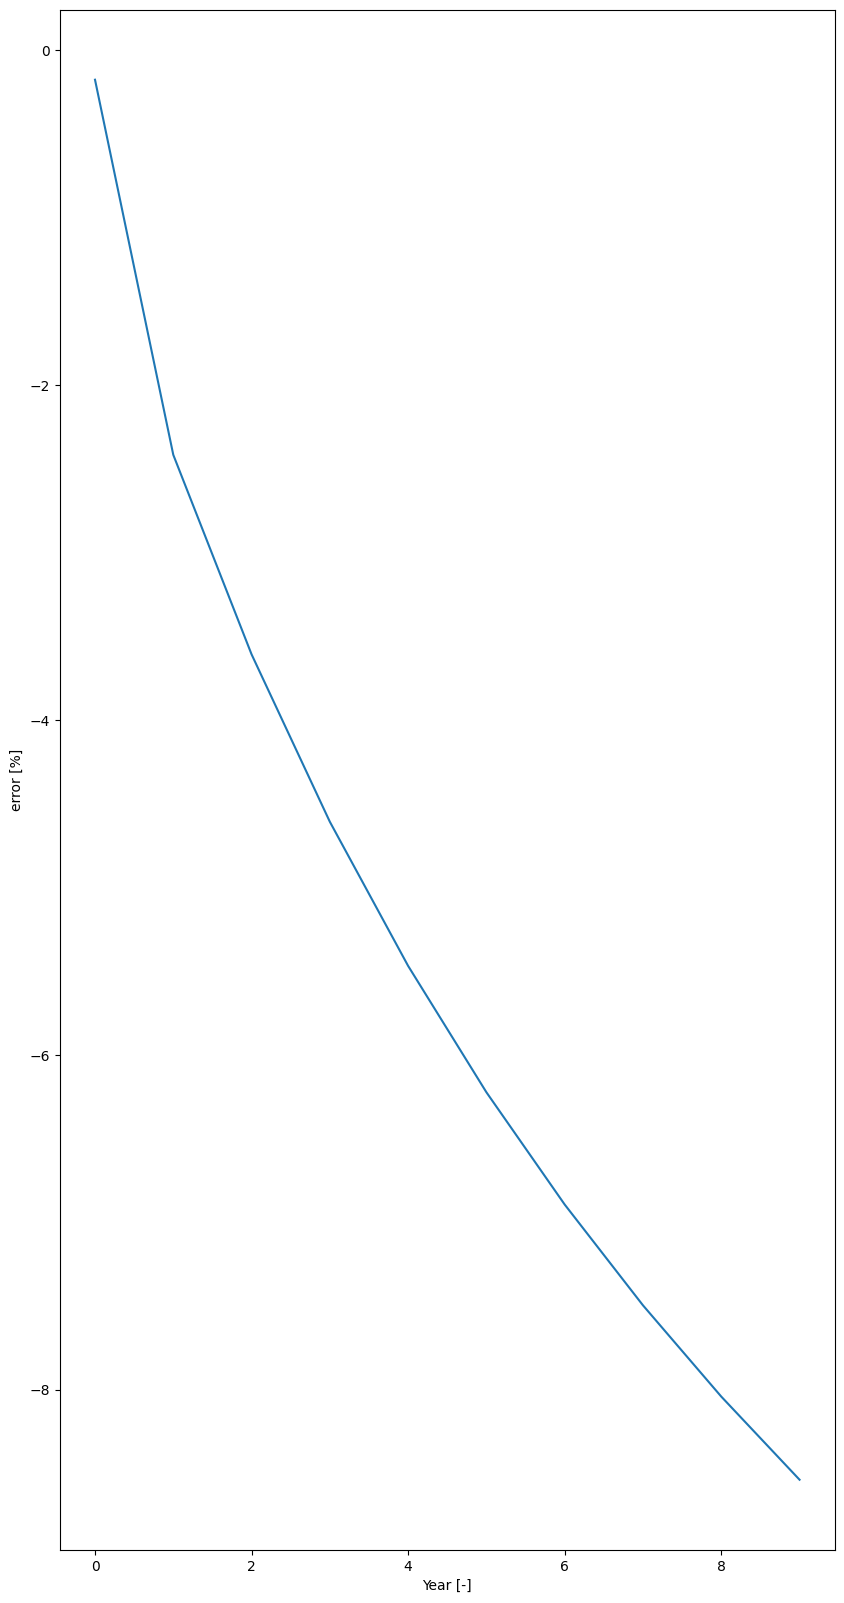

In [8]:
error = []
for t in range(10):
  calc = (molWg2[t]-molWg[t])/molWg[t]*100
  error.append(calc)
print(molWg)
print(molWg2)
plt.plot(time, error)
plt.xlabel('Year [-]')
plt.ylabel('error [%]')
plt.show()

We observe that error in gas molecular weight increase with time. Calculated gas is lighther that real, because gas has been stripped off in reservoir during depletion.

We then compare methane in reservoir fluid from true to recombined of reservoir fluid

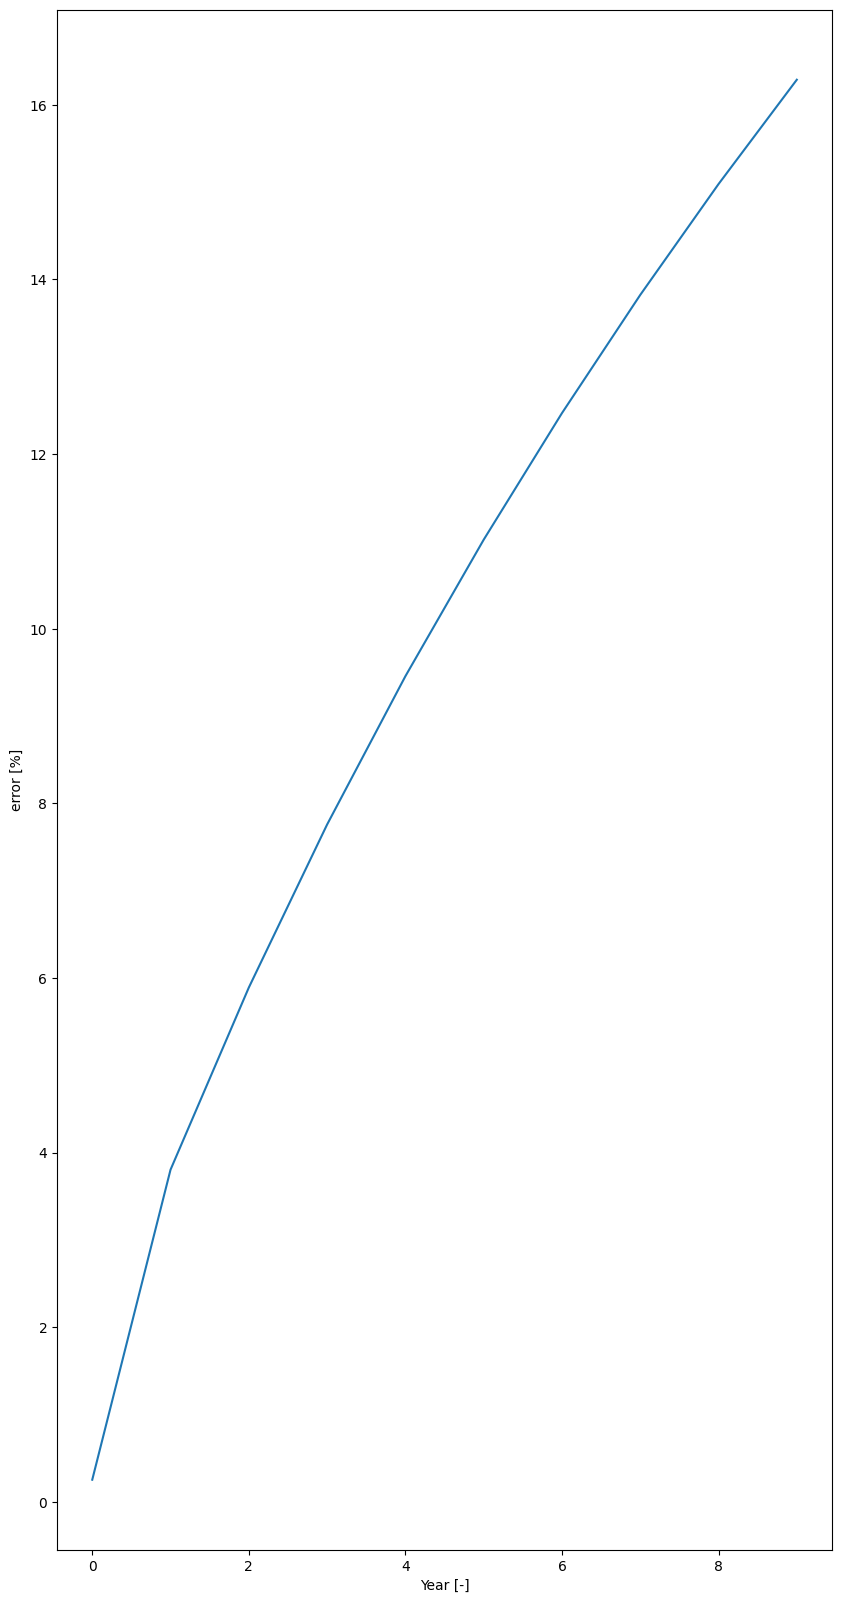

In [9]:
error = []
name = 'methane'
for t in range(10):
  calc = (recombinedfluid[t].getFluid().getComponent(name).getz() - production[t].getFluid().getComponent(name).getz())/production[t].getFluid().getComponent(name).getz()*100
  error.append(calc)

plt.plot(time, error)
plt.xlabel('Year [-]')
plt.ylabel('error [%]')
plt.show()

We see that methane will start to deviate

#Step 6. Improving by running CME of original reservoir fluid

In [10]:
gasflow3 = []
oilflow3 = []
molWg3 = []
recombinedfluid2 = []

for t in range(10):
  fluidorg = fluid1.clone()
  fluidorg.setPressure(pressure[t])
  TPflash(fluidorg)
  feedstream = stream(fluidorg.phaseToSystem('oil'))
  feedstream.run()

  flowset =  jNeqSim.processSimulation.processEquipment.util.FlowSetter("flowset", feedstream)
  pressureSep = [1.01325]
  temperatureSep = [15.0]
  flowset.setSeparationPT(JDouble[:](pressureSep), "bara", JDouble[:](temperatureSep), "C");
  flowset.setGasFlowRate(gasflow[t], "MSm3/day")
  flowset.setOilFlowRate(oilflow[t], "m3/hr")
  flowset.run()
  recombinedfluid2.append(flowset.getOutStream())

  wellTP = heater(flowset.getOutStream())
  wellTP.setOutTemperature(15.0, 'C')
  wellTP.setOutPressure(1.01325, 'bara')
  wellTP.run()

  sep1 = separator(wellTP.getOutStream())
  sep1.run()

  gasflow3.append(sep1.getGasOutStream().getFlowRate('MSm3/day'))
  oilflow3.append(sep1.getLiquidOutStream().getFlowRate('m3/hr'))
  molWg3.append(sep1.getGasOutStream().getFluid().getMolarMass())

  print('gas ' , sep1.getGasOutStream().getFlowRate('MSm3/day'), 'MSm3/day')
  print('oil ' , sep1.getLiquidOutStream().getFlowRate('m3/hr')*24, 'm3/day')
  print('gas ' , sep1.getGasOutStream().getFlowRate('kg/day'), 'kg/day')
  print('oil ' , sep1.getLiquidOutStream().getFlowRate('kg/day'), 'kg/day')

gas  7.876524169012968 MSm3/day
oil  50327.27481181623 m3/day
gas  8872411.490331702 kg/day
oil  41127905.22271216 kg/day
gas  7.402138010282817 MSm3/day
oil  55050.33859655254 m3/day
gas  8528264.741803035 kg/day
oil  44957510.46646307 kg/day
gas  5.856603871827609 MSm3/day
oil  47116.72805092643 m3/day
gas  6830947.255418253 kg/day
oil  38462789.095020294 kg/day
gas  5.119919685368452 MSm3/day
oil  43981.366017630586 m3/day
gas  6034443.721836159 kg/day
oil  35890403.5311653 kg/day
gas  4.56722612756854 MSm3/day
oil  41518.2693371959 m3/day
gas  5432322.926985177 kg/day
oil  33869586.35914411 kg/day
gas  4.132910625171047 MSm3/day
oil  39496.98920032779 m3/day
gas  4955665.321790059 kg/day
oil  32211408.32528983 kg/day
gas  3.78026136500288 MSm3/day
oil  37788.22188398868 m3/day
gas  4565888.549015275 kg/day
oil  30809804.0615426 kg/day
gas  3.4868245632088173 MSm3/day
oil  36312.09779948226 m3/day
gas  4239361.077209762 kg/day
oil  29599230.42552343 kg/day
gas  3.2379570416404815 MS

[0.02663376014394207, 0.02724538876585223, 0.027582322348705352, 0.02787154115359825, 0.02812543732793007, 0.028351845689764683, 0.028556089342773122, 0.02874197586051126, 0.028912336329680904, 0.02906934034528859]
[0.026634419462825208, 0.02724204243112979, 0.027578538741902126, 0.027868286231481142, 0.02812349130918538, 0.028351897143424364, 0.02855877981805973, 0.028747923524359086, 0.0289221496206074, 0.02908362647976463]


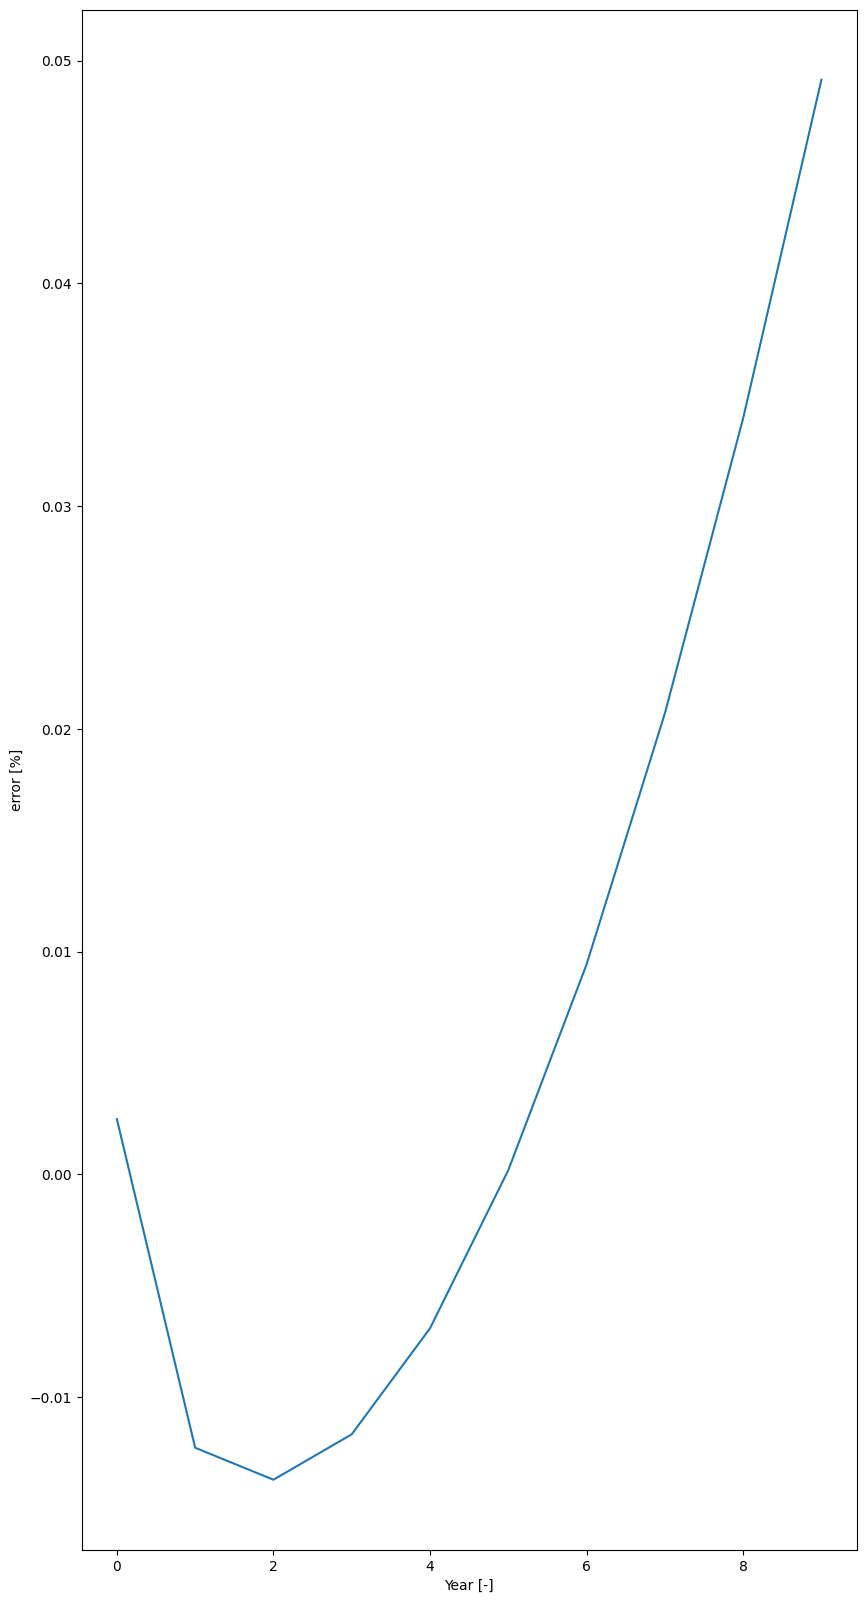

In [11]:
error = []
for t in range(10):
  calc = (molWg3[t]-molWg[t])/molWg[t]*100
  error.append(calc)
print(molWg)
print(molWg3)
plt.plot(time, error)
plt.xlabel('Year [-]')
plt.ylabel('error [%]')
plt.show()

We see a significant imporvment in molecular weight calculation.

We then compare methan in reservoir fluid.

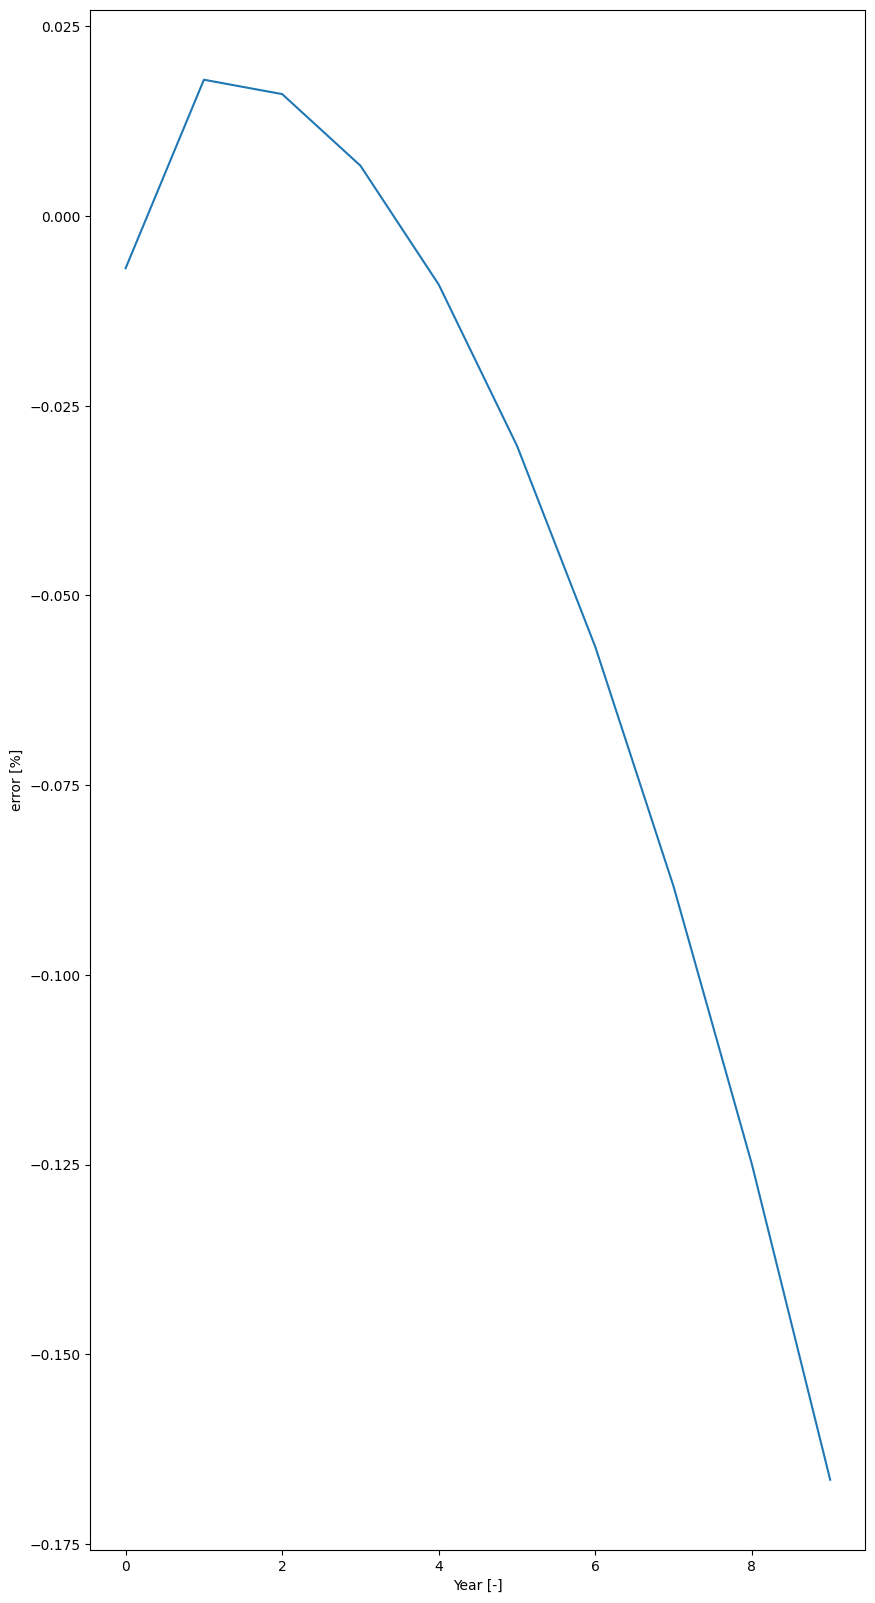

In [12]:
error = []
name = 'methane'
for t in range(10):
  calc = (recombinedfluid2[t].getFluid().getComponent(name).getz() - production[t].getFluid().getComponent(name).getz())/production[t].getFluid().getComponent(name).getz()*100
  error.append(calc)

plt.plot(time, error)
plt.xlabel('Year [-]')
plt.ylabel('error [%]')
plt.show()

We see that results have improved considerably for reservoir fluid composition.

We see that be running a CME the results improve a lot.

#Step 7. Run process simulation with corrected fluid composition and real compositon

##Case 1: first we run with real composition (from reservoir simulation)

In [13]:
#select year
year = 0

In [14]:
inputdata = {
  'topsidePressure': 90.0,
  'topsideTemperature': 86.16,
  'temperatureOilHeater' : 60.0,
  'temperatureOilHeater2' : 91.0,
  'secondStagePressure': 22.4,
  'thirdStagePressure': 5.7,
  'fourthStagePressure': 1.96,
  'firstStageSuctionCoolerTemperature': 45.0,
  'secondStageSuctionCoolerTemperature': 40.0,
  'thirdStageSuctionCoolerTemperature':35,
  'dewPointSuctionCoolerTemperature':35,
  'firstStageExportCoolerTemperature': 35,
  'secondStageExportCoolerTemperature': 35,
  'thirdStageExportCoolerTemperature': 35,
  'firststageexportpressure': 250.0,
  'secondstageexportpressure': 474.0,
  'thirdstageexportpressure': 633.0,
}

In [15]:
from neqsim.thermo import fluid, printFrame
from neqsim.process import compsplitter, compressor, splitter, cooler, separator3phase, getProcess, clearProcess, mixer, heater, stream, pump, separator, runProcess, stream, saturator, valve, filters, heatExchanger, simpleTEGAbsorber,distillationColumn, waterStripperColumn, recycle2, setpoint, calculator


fluidinp = production[year].getFluid().clone()
fluidinp.addComponent('water', 100.0)
fluidinp.setMixingRule(2)
fluidinp.setMultiPhaseCheck(True)
fluidinp.setPressure(inputdata['topsidePressure'], 'bara')
fluidinp.setTemperature(50.0, 'C')
TPflash(fluidinp)

clearProcess()

wellFluid = stream(fluidinp)
wellFluid.setPressure(inputdata['topsidePressure'], "bara")
wellFluid.run()

feedTPsetter = heater(wellFluid)
feedTPsetter.setName('inletTP')
feedTPsetter.setOutPressure(inputdata['topsidePressure'], "bara")
feedTPsetter.setOutTemperature(inputdata['topsideTemperature'], "C")

feedToOffshoreProcess = stream(feedTPsetter.getOutStream())
feedToOffshoreProcess.setName("feed to offshore")

firstStageSeparator = separator3phase(feedToOffshoreProcess)
firstStageSeparator.setName("1st stage separator")

oilThrotValve = valve(firstStageSeparator.getOilOutStream())
oilThrotValve.setName("valve oil from first stage")
oilThrotValve.setOutletPressure(inputdata['secondStagePressure'])

oilThirdStageToMix2 =  stream(wellFluid.clone())
oilThirdStageToMix2.setName("resyc oil to mixer 2")

HPMixer = mixer("HP oil mixer")
HPMixer.addStream(oilThrotValve.getOutStream())
HPMixer.addStream(oilThirdStageToMix2)

oilHeaterFromFirstStage = heater(HPMixer.getOutStream())
oilHeaterFromFirstStage.setName("oil heater second stage")
oilHeaterFromFirstStage.setOutTemperature(inputdata['temperatureOilHeater'],'C')

secondStageSeparator = separator3phase(oilHeaterFromFirstStage.getOutStream())
secondStageSeparator.addStream(oilThirdStageToMix2)
secondStageSeparator.setName("2nd stage separator")

oilHeaterFromSecondStage = heater(secondStageSeparator.getOilOutStream())
oilHeaterFromSecondStage.setName("oil heater third stage")
oilHeaterFromSecondStage.setOutTemperature(inputdata['temperatureOilHeater2'],'C')

oilThrotValve2 = valve(oilHeaterFromSecondStage.getOutStream())
oilThrotValve2.setName("valve oil from second stage")
oilThrotValve2.setOutletPressure(inputdata['thirdStagePressure'])

thirdStageSeparator = separator3phase(oilThrotValve2.getOutStream())
thirdStageSeparator.setName("3rd stage separator")

oilThirdStageToSep =  stream(wellFluid.clone())
oilThirdStageToSep.setName("resyc oil")
thirdStageSeparator.addStream(oilThirdStageToSep)

oilThrotValve3 = valve(thirdStageSeparator.getOilOutStream())
oilThrotValve3.setName("valve oil from third stage")
oilThrotValve3.setOutletPressure(inputdata['fourthStagePressure'])

fourthStageSeparator = separator3phase(oilThrotValve3.getOutStream())
fourthStageSeparator.setName("4th stage separator")

stableOil = stream(fourthStageSeparator.getOilOutStream())
stableOil.setName("stable oil")

stableOilPump = pump(stableOil,15.0,"stable oil pump")

firstStageCooler = cooler(fourthStageSeparator.getGasOutStream())
firstStageCooler.setName("1st stage cooler")
firstStageCooler.setOutTemperature(inputdata['firstStageSuctionCoolerTemperature'],'C')

firstStageScrubber = separator(firstStageCooler.getOutStream())
firstStageScrubber.setName("1st stage scrubber")

firstStageCompressor = compressor(firstStageScrubber.getGasOutStream())
firstStageCompressor.setName("1st stage compressor")
firstStageCompressor.setOutletPressure(inputdata['thirdStagePressure'])
firstStageCompressor.setIsentropicEfficiency(0.75)

secondstageGasMixer = mixer("seccond Stage mixer")
secondstageGasMixer.addStream(firstStageCompressor.getOutStream())
secondstageGasMixer.addStream(thirdStageSeparator.getGasOutStream())

secondStageCooler = cooler(secondstageGasMixer.getOutStream())
secondStageCooler.setName("2nd stage cooler")
secondStageCooler.setOutTemperature(inputdata['secondStageSuctionCoolerTemperature'],'C')

secondStageScrubber = separator(secondStageCooler.getOutStream())
secondStageScrubber.setName("2nd stage scrubber")

secondStageCompressor = compressor(secondStageScrubber.getGasOutStream())
secondStageCompressor.setName("2nd stage compressor")
secondStageCompressor.setOutletPressure(inputdata['secondStagePressure'])
secondStageCompressor.setIsentropicEfficiency(0.75)

thirdstageGasMixer = mixer("third Stage mixer")
thirdstageGasMixer.addStream(secondStageCompressor.getOutStream())
thirdstageGasMixer.addStream(secondStageSeparator.getGasOutStream())

thirdStageCooler = cooler(thirdstageGasMixer.getOutStream())
thirdStageCooler.setName("3rd stage cooler")
thirdStageCooler.setOutTemperature(inputdata['thirdStageSuctionCoolerTemperature'],'C')

thirdStageScrubber = separator(thirdStageCooler.getOutStream())
thirdStageScrubber.setName("3rd stage scrubber")

thirdStageCompressor = compressor(thirdStageScrubber.getGasOutStream())
thirdStageCompressor.setName("3rd stage compressor")
thirdStageCompressor.setOutletPressure(inputdata['topsidePressure'])
thirdStageCompressor.setIsentropicEfficiency(0.75)

richGasMixer = mixer("fourth Stage mixer")
richGasMixer.addStream(thirdStageCompressor.getOutStream())
richGasMixer.addStream(firstStageSeparator.getGasOutStream())

dewPointControlCooler = cooler(richGasMixer.getOutStream())
dewPointControlCooler.setName("dew point cooler")
dewPointControlCooler.setOutTemperature(inputdata['dewPointSuctionCoolerTemperature'],'C')

dewPointScrubber = separator(dewPointControlCooler.getOutStream())
dewPointScrubber.setName("dew point scrubber")

lpLiqmixer = mixer("LP liq mixer");
lpLiqmixer.addStream(firstStageScrubber.getLiquidOutStream());
lpLiqmixer.addStream(secondStageScrubber.getLiquidOutStream());
lpLiqmixer.addStream(thirdStageScrubber.getLiquidOutStream());

hpResycle = recycle2("HP liq resycle")
hpResycle.addStream(dewPointScrubber.getLiquidOutStream())
hpResycle.setOutletStream(oilThirdStageToMix2)

lpResycle = recycle2("LP liq resycle")
lpResycle.addStream(lpLiqmixer.getOutStream())
lpResycle.setOutletStream(oilThirdStageToSep)

exportCompressor1 = compressor(dewPointScrubber.getGasOutStream())
exportCompressor1.setName("export 1st stage")
exportCompressor1.setOutletPressure(inputdata['firststageexportpressure'])
exportCompressor1.setIsentropicEfficiency(0.75)

exportCooler = cooler(exportCompressor1.getOutStream())
exportCooler.setName("export cooler")
exportCooler.setOutTemperature(inputdata['secondStageExportCoolerTemperature'],'C')

exportGas = stream(exportCooler.getOutStream())
exportGas.setName("export gas")

oilprocess = getProcess()

In [16]:
printFrame(fluidinp)

| 0                  | 1           | 2           | 3           | 4           | 5   | 6               |
|:-------------------|:------------|:------------|:------------|:------------|:----|:----------------|
|                    | total       | GAS         | OIL         | AQUEOUS     |     |                 |
| nitrogen           | 3.78908E-3  | 1.15489E-2  | 1.49928E-3  | 1.48908E-8  |     | [mole fraction] |
| CO2                | 2.95929E-3  | 4.30803E-3  | 2.59722E-3  | 2.08358E-6  |     | [mole fraction] |
| methane            | 3.93994E-1  | 8.40243E-1  | 2.65065E-1  | 2.48411E-7  |     | [mole fraction] |
| ethane             | 7.50757E-2  | 7.67329E-2  | 7.57476E-2  | 2.41337E-10 |     | [mole fraction] |
| propane            | 7.86534E-2  | 4.18162E-2  | 9.10342E-2  | 3.24732E-12 |     | [mole fraction] |
| i-butane           | 1.17882E-2  | 3.92297E-3  | 1.43535E-2  | 1.10899E-15 |     | [mole fraction] |
| n-butane           | 4.04448E-2  | 1.06079E-2  | 5.01091E-2  | 4.43042E

In [17]:
#oilprocess.run() #run this to finish thread before continuing
thread = oilprocess.runAsThread()
thread.join(50000) # set maximum time to 50000 msec before continuing

In [18]:
TVP = stableOil.TVP(20.0, 'C')
cricondenbar = exportGas.CCB('bara')
powerComp1 = oilprocess.getUnit("1st stage compressor").getPower()/1.0e3
powerComp2 = oilprocess.getUnit("2nd stage compressor").getPower()/1.0e3
powerComp3 = oilprocess.getUnit("3rd stage compressor").getPower()/1.0e3
powerExpComp1 = oilprocess.getUnit("export 1st stage").getPower()/1.0e3


flowRate = exportGas.getFlowRate('MSm3/day')
flowRateOil = stableOilPump.getOutStream().getFlowRate('kg/hr')
oildensity = stableOilPump.getOutStream().getFluid().getDensity('kg/m3')
oilkbblperday = flowRateOil/oildensity*6.29*24/1e3

print('feed flow [kg/hr] ', feedToOffshoreProcess.getFlowRate('kg/hr')/1e6)
print('TVP [bara] ', TVP)
print('cricondenbar [bara] ', cricondenbar)
print('recomp power 1 [kW] ', powerComp1)
print('recomp power 2 [kW] ', powerComp2)
print('recomp power 3 [kW] ', powerComp3)
print('exp power 1 [kW] ', powerExpComp1)
print('gas export [MSm3/d] ', flowRate)
print('oil export [m3/hr] ', flowRateOil/oildensity)
print('oil export [kbbl/day] ', flowRateOil/oildensity*6.29*24/1e3)
print('oil export [10^6*kg/hr] ', flowRateOil/1e6)
print('oil density [kg/m3] ', oildensity)

feed flow [kg/hr]  2.0898187333333342
TVP [bara]  0.6319929100778636
cricondenbar [bara]  0.0
recomp power 1 [kW]  2828.6635412374026
recomp power 2 [kW]  9131.095638573248
recomp power 3 [kW]  18193.924660582998
exp power 1 [kW]  12713.293783228255
gas export [MSm3/d]  9.954518896710553
oil export [m3/hr]  2337.3159932505896
oil export [kbbl/day]  352.841222341109
oil export [10^6*kg/hr]  1.8245022810826583
oil density [kg/m3]  780.5971834151775


In [19]:
printFrame(exportGas.getFluid())
printFrame(stableOil.getFluid())

| 0                  | 1           | 2           | 3            | 4   | 5   | 6               |
|:-------------------|:------------|:------------|:-------------|:----|:----|:----------------|
|                    | total       | GAS         | AQUEOUS      |     |     |                 |
| nitrogen           | 5.62138E-3  | 5.62294E-3  | 1.07604E-8   |     |     | [mole fraction] |
| CO2                | 5.23299E-3  | 5.23445E-3  | 2.58135E-6   |     |     | [mole fraction] |
| methane            | 6.4007E-1   | 6.40248E-1  | 1.41691E-7   |     |     | [mole fraction] |
| ethane             | 1.45564E-1  | 1.45605E-1  | 9.79528E-11  |     |     | [mole fraction] |
| propane            | 1.44436E-1  | 1.44476E-1  | 8.91048E-13  |     |     | [mole fraction] |
| i-butane           | 1.40682E-2  | 1.40721E-2  | 1.184E-16    |     |     | [mole fraction] |
| n-butane           | 3.52418E-2  | 3.52516E-2  | 3.87646E-16  |     |     | [mole fraction] |
| i-pentane          | 3.69001E-3  | 3.6


##Case 2: run topside process simulation with simplified composition (recombined fluid)

In [20]:
fluidinp2 = recombinedfluid[year].getFluid().clone()
fluidinp2.addComponent('water', 100.0)
fluidinp2.setMixingRule(2)
fluidinp2.setMultiPhaseCheck(True)
fluidinp2.setPressure(inputdata['topsidePressure'], 'bara')
fluidinp2.setTemperature(50.0, 'C')
TPflash(fluidinp2)

wellFluid.setFluid(fluidinp2)
wellFluid.setPressure(inputdata['topsidePressure'], "bara")
wellFluid.run()

#oilprocess.run() #run this to finish thread before continuing
thread = oilprocess.runAsThread()
thread.join(50000) # set maximum time to 50000 msec before continuing

TVP = stableOil.TVP(20.0, 'C')
cricondenbar = exportGas.CCB('bara')
powerComp1 = oilprocess.getUnit("1st stage compressor").getPower()/1.0e3
powerComp2 = oilprocess.getUnit("2nd stage compressor").getPower()/1.0e3
powerComp3 = oilprocess.getUnit("3rd stage compressor").getPower()/1.0e3
powerExpComp1 = oilprocess.getUnit("export 1st stage").getPower()/1.0e3


flowRate = exportGas.getFlowRate('MSm3/day')
flowRateOil = stableOilPump.getOutStream().getFlowRate('kg/hr')
oildensity = stableOilPump.getOutStream().getFluid().getDensity('kg/m3')
oilkbblperday = flowRateOil/oildensity*6.29*24/1e3

print('feed flow [kg/hr] ', feedToOffshoreProcess.getFlowRate('kg/hr')/1e6)
print('TVP [bara] ', TVP)
print('cricondenbar [bara] ', cricondenbar)
print('recomp power 1 [kW] ', powerComp1)
print('recomp power 2 [kW] ', powerComp2)
print('recomp power 3 [kW] ', powerComp3)
print('exp power 1 [kW] ', powerExpComp1)
print('gas export [MSm3/d] ', flowRate)
print('oil export [m3/hr] ', flowRateOil/oildensity)
print('oil export [kbbl/day] ', flowRateOil/oildensity*6.29*24/1e3)
print('oil export [10^6*kg/hr] ', flowRateOil/1e6)
print('oil density [kg/m3] ', oildensity)

feed flow [kg/hr]  2.089254776099895
TVP [bara]  0.6334004779864044
cricondenbar [bara]  1.3498588075760032
recomp power 1 [kW]  4823618618.763981
recomp power 2 [kW]  -832594988092.6178
recomp power 3 [kW]  -58087.898146582134
exp power 1 [kW]  11280.6256954787
gas export [MSm3/d]  8.650307565822107
oil export [m3/hr]  2238.5878562618577
oil export [kbbl/day]  337.93722278129
oil export [10^6*kg/hr]  1.761340169946484
oil density [kg/m3]  786.8085967765796


In [24]:
printFrame(exportGas.getFluid())
printFrame(stableOil.getFluid())

| 0                  | 1           | 2           | 3            | 4   | 5   | 6               |
|:-------------------|:------------|:------------|:-------------|:----|:----|:----------------|
|                    | total       | GAS         | AQUEOUS      |     |     |                 |
| nitrogen           | 6.05895E-3  | 6.06068E-3  | 1.1382E-8    |     |     | [mole fraction] |
| CO2                | 5.13956E-3  | 5.14103E-3  | 2.53257E-6   |     |     | [mole fraction] |
| methane            | 6.55881E-1  | 6.56067E-1  | 1.44109E-7   |     |     | [mole fraction] |
| ethane             | 1.38984E-1  | 1.39024E-1  | 9.41856E-11  |     |     | [mole fraction] |
| propane            | 1.38062E-1  | 1.38101E-1  | 8.66292E-13  |     |     | [mole fraction] |
| i-butane           | 1.31618E-2  | 1.31655E-2  | 1.13364E-16  |     |     | [mole fraction] |
| n-butane           | 3.22822E-2  | 3.22914E-2  | 3.64636E-16  |     |     | [mole fraction] |
| i-pentane          | 3.5682E-3   | 3.5

#Create well streams, fit to gas and oil rates from reservoir simulation, mix and separate

In [21]:
from neqsim.process import  mixer, heater, stream, separator, GORfitter

In [22]:
#from eclipse
gas_flow = 1.0 #MSm3/day
oil_flow = 2000.0 #m3/hr
water_flow = 1000.0 #m3/hr

# Creating Well 1
well1 = stream(fluid1.clone())
molar_composition_well1 = [
    0.003912, 0.003010, 0.303275, 0.076341, 0.079752, 0.011938, 0.040929,
    0.013944, 0.021568, 0.027988, 0.042936, 0.043237, 0.030898, 0.043939,
    0.045143, 0.022571, 0.025180, 0.021188, 0.014111, 0.012845, 0.008955,
    0.006340
]
well1.getFluid().setMolarComposition(molar_composition_well1)
well1.run()

flowset =  jNeqSim.processSimulation.processEquipment.util.FlowSetter("flowset", well1)
flowset.setGasFlowRate(gas_flow, "MSm3/day")
flowset.setOilFlowRate(oil_flow, "m3/hr")
flowset.run()

well1Fitted = flowset.getOutStream()

#Creating Well 2
gas_flow2 = 1.0 #MSm3/day
oil_flow2 = 1200.0 #m3/hr

well2 = stream(fluid1.clone())
molar_composition_well2 = [
    0.003912, 0.003010, 0.403275, 0.076341, 0.079752, 0.011938, 0.040929,
    0.013944, 0.021568, 0.027988, 0.042936, 0.043237, 0.030898, 0.043939,
    0.045143, 0.022571, 0.025180, 0.021188, 0.014111, 0.012845, 0.008955,
    0.006340
]
well2.getFluid().setMolarComposition(molar_composition_well2)
well2.run()

flowset2 =  jNeqSim.processSimulation.processEquipment.util.FlowSetter("flowset", well2)
flowset2.setGasFlowRate(gas_flow2, "MSm3/day")
flowset2.setOilFlowRate(oil_flow2, "m3/hr")
flowset2.run()
well2Fitted = flowset2.getOutStream()


#Mixing stream
wellmixer = mixer('well mixer')
wellmixer.addStream(well1Fitted)
wellmixer.addStream(well2Fitted)
wellmixer.run()

#Setting pressure and temperature of inlet separator
wellTP = heater(wellmixer.getOutStream())
wellTP.setOutTemperature(15.0, 'C')
wellTP.setOutPressure(1.01325, 'bara')
wellTP.run()

#creating a inlet separator
inletsep = separator(wellTP.getOutStream())
inletsep.run()



gasFlowRate = inletsep.getGasOutStream().getFlowRate('MSm3/day')
gasAFlowRate = inletsep.getGasOutStream().getFlowRate('m3/hr')
oilFlowRate = inletsep.getLiquidOutStream().getFlowRate('m3/hr')

print('gas flow rate from separator ', gasFlowRate, ' MSm3/hr')
print('gas flow rate from separator ', gasAFlowRate, ' Am3/hr')
print('oil flow rate from separator ', oilFlowRate, ' m3/hr')

print('GOR from surface ', gasAFlowRate/oilFlowRate)

gas flow rate from separator  2.00554782726719  MSm3/hr
gas flow rate from separator  82997.27293002271  Am3/hr
oil flow rate from separator  3199.1179572277038  m3/hr
GOR from surface  25.94379889697678


##Running a CME simulation for the reservoir fluid

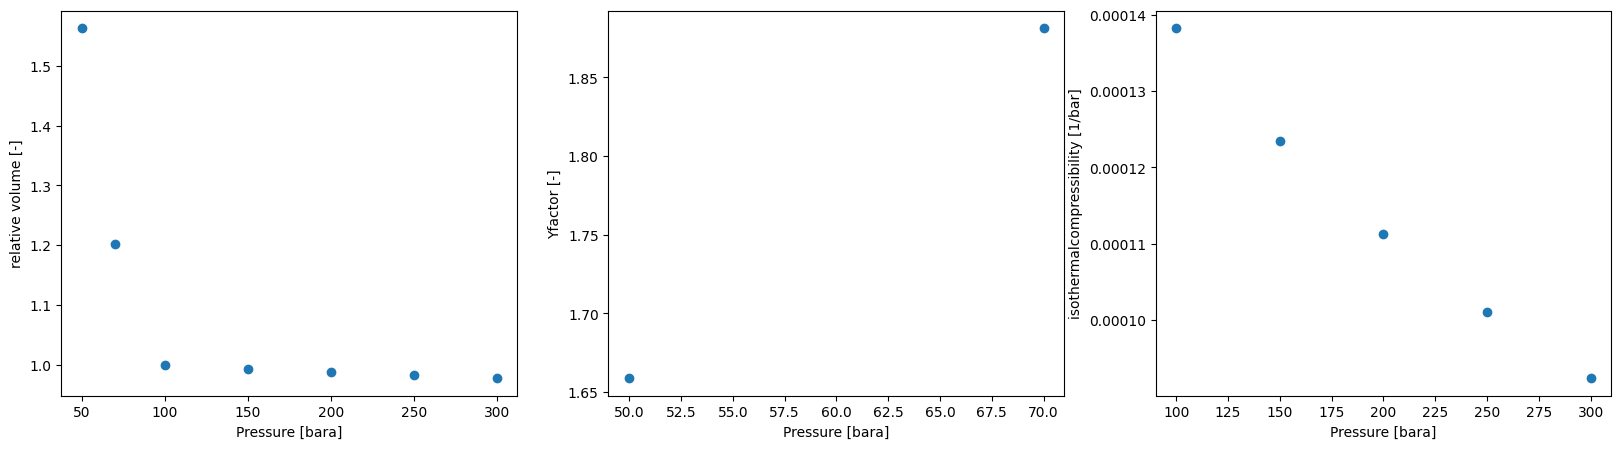

In [23]:
fluid1 = well1.getFluid().clone()

pressure = [300.0, 250.0, 200.0, 150.0, 100.0, 70.0, 50.0]
temperature = [301.0, 301.0, 301.0, 301.0, 301.0, 301.0, 301.0]

relativevolume = []
liquidrelativevolume = []
Zgas =  []
Yfactor = []
isothermalcompressibility = []
satPressure = None
CME(fluid1,pressure,temperature,satPressure,relativevolume, liquidrelativevolume,Zgas,Yfactor,isothermalcompressibility)

plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.plot(pressure, relativevolume, "o")
plt.xlabel('Pressure [bara]')
plt.ylabel('relative volume [-]')
plt.subplot(132)
plt.plot(pressure, Yfactor, "o")
plt.xlabel('Pressure [bara]')
plt.ylabel('Yfactor [-]')
plt.subplot(133)
plt.plot(pressure, isothermalcompressibility, "o")
plt.xlabel('Pressure [bara]')
plt.ylabel('isothermalcompressibility [1/bar]')
plt.show()